## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

## Table of Contents

[1. Explore training data](#part1)<br>
[2. Classify customer on training data](#part2)<br>
$\;\;\;\;\;\;$[2.1 Normalize data](#part2.1)<br>
$\;\;\;\;\;\;$[2.2 Train classifier](#part2.2)<br>
$\;\;\;\;\;\;$[2.3 Optimize threshold](#part2.3)<br>
[3. Predict on test data](#part3)<br>

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing, svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

import xgboost as xgb

%matplotlib inline

## <a class="anchor" id="part1"> 1. Explore training data </a>

In [2]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [3]:
train_data.isna().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [4]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


Define function to calculate IRR and NIR

In [5]:
def cal_IRR_NIR(df, label_purch, flag_print):
    '''    
    Function:
    calculate IRR and NIR for input data
    
    INPUT:
    df - 2D pandas dataframe 
    purch - 1D array of purchase label
    flag_print - integer for print option
    
    Output:
    IRR - real number for Incremental Response Rate
    NIR - real number for Net Incremental Revenue 
    
    '''
    # Reset purchase label
    df['purchase'] = label_purch
    
    # Get data for treated group
    cust_treat = df.query('Promotion=="Yes"')
    purch_treat = cust_treat[cust_treat['purchase']==1]
    
    # Get data for controled group
    cust_ctrl = df.query('Promotion=="No"')
    purch_ctrl = cust_ctrl[cust_ctrl['purchase']==1]

    IRR = purch_treat.shape[0]/cust_treat.shape[0] - purch_ctrl.shape[0]/cust_ctrl.shape[0]
    NIR = (purch_treat.shape[0]*10 - cust_treat.shape[0]*0.15) - purch_ctrl.shape[0]*10
    
    if (flag_print == 1):
        print('cust_treat: {}, purch_treat: {}, cust_ctrl: {}, purch_ctrl: {}'. \
              format(cust_treat.shape[0], purch_treat.shape[0], cust_ctrl.shape[0], purch_ctrl.shape[0]))
        print('Purchase Rate:',(purch_treat.shape[0]+purch_ctrl.shape[0])/(cust_treat.shape[0]+cust_ctrl.shape[0]))
        print ('Incremental Response Rate (IRR): {}'.format(round(IRR,4)))
        print ('Net Incremental Revenue (NIR): {}'.format(round(NIR)))
    
    return IRR, NIR

In [6]:
IRR, NIR = cal_IRR_NIR(train_data, train_data['purchase'],1)

cust_treat: 42364, purch_treat: 721, cust_ctrl: 42170, purch_ctrl: 319
Purchase Rate: 0.012302742091939338
Incremental Response Rate (IRR): 0.0095
Net Incremental Revenue (NIR): -2335


look at pairwise relationships for all of the explanatory variables.

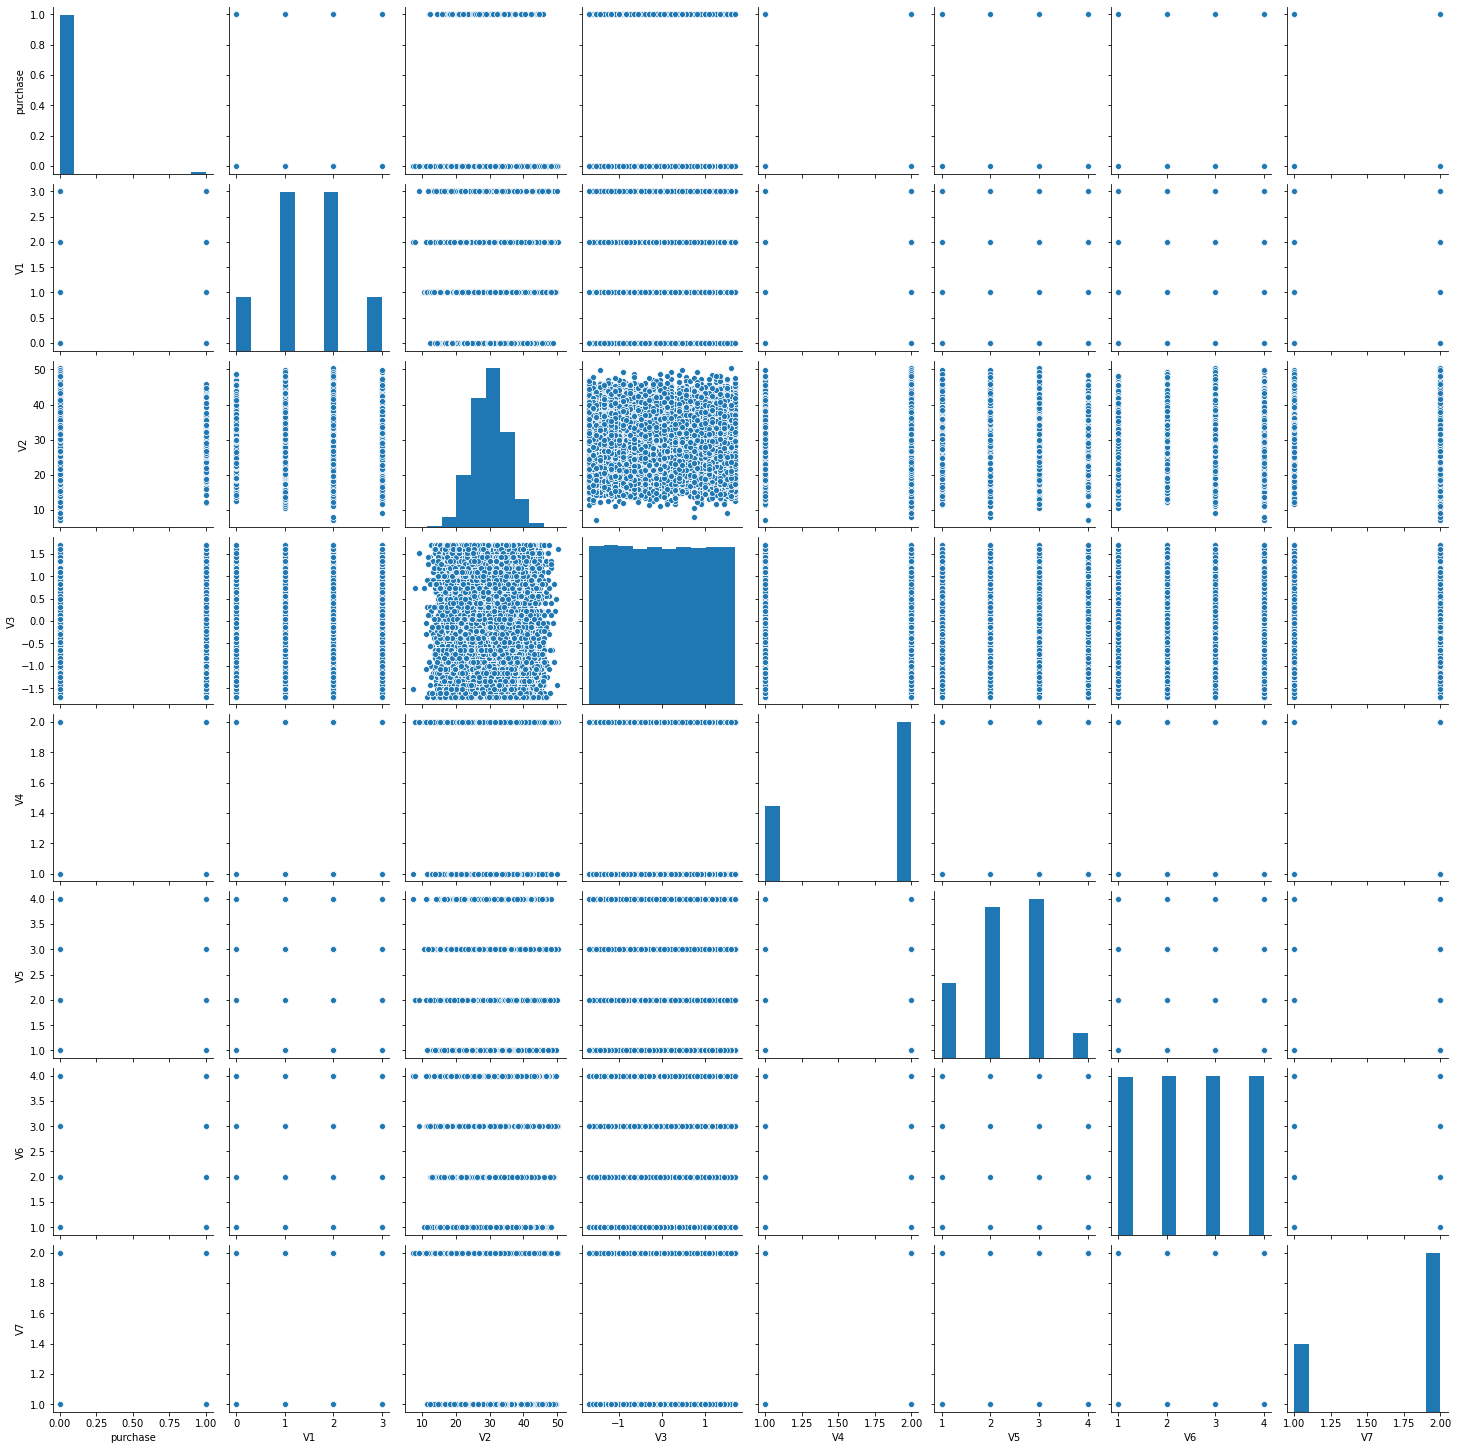

In [7]:
# Check correlation
sns.pairplot(train_data[['purchase','V1', 'V2', 'V3','V4','V5','V6','V7']]);

Also check the colinearity by calculating the VIFs for each variable in your model

In [8]:
y, X = dmatrices('purchase ~ V1+V2+V3+V4+V5+V6+V7', train_data, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Features'] = X.columns
vif

,VIF Factor,Features
0,79.357067,Intercept
1,1.000042,V1
2,1.000036,V2
3,1.000056,V3
4,1.000056,V4
5,1.000038,V5
6,1.000069,V6
7,1.000033,V7


There is no obvious linear relationship between variables.

Check the feature distribution in purchase group and non-purchase group. Their distributions are very similar.

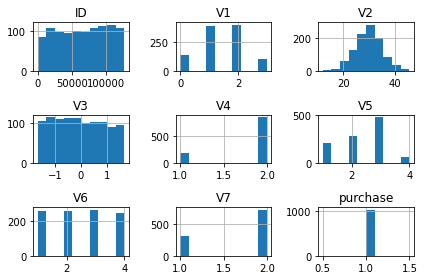

In [9]:
train_data.query('purchase ==1').hist();
plt.tight_layout();

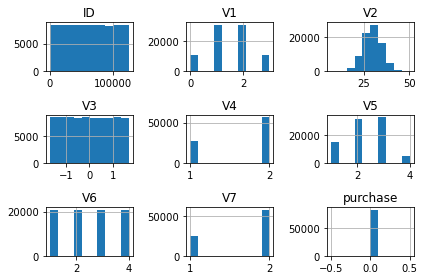

In [10]:
train_data.query('purchase ==0').hist();
plt.tight_layout();

## <a class="anchor" id="part2"> 2. Classify customer on training data </a> 

### <a class="anchor" id="part2.1"> 2.1 Normalize data </a>  

Data Standardization give data zero mean and unit variance.

In [11]:
# Normalization
X = train_data[['V1','V2','V3','V4','V5','V6','V7']]
X_train = preprocessing.StandardScaler().fit(X).transform(X)
y_train = train_data['purchase']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

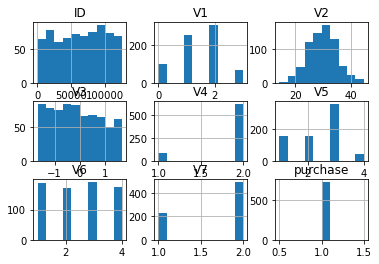

In [12]:
train_data.query('Promotion=="Yes" & purchase ==1').hist();

### <a class="anchor" id="part2.2"> 2.2 Train classifier </a>

Define function below to plot ROC curve

In [13]:
def plot_roc(y, y_pred):
    '''
    INPUT:
    y - 1D array of actual class
    y_pred - 1D array of predicted class
    
    OUTPUT: 
    None
    
    This function plot ROC curve for input data
    '''
    fpr, tpr, _ = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',linewidth=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

- Logistic Regression

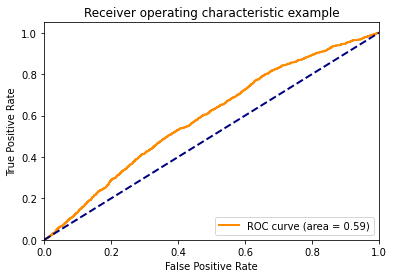

array([[76607,  6887],
       [  927,   113]], dtype=int64)

In [14]:
# Define Logistic Regression Classifier
LR = LogisticRegression(C=0.01, solver='liblinear')

# Fit model on training data
LR.fit(X_train,y_train)

# Predict on training data
# Predict probability
predict_prob = LR.predict_proba(X_train)
# Plot ROC curve
plot_roc(y_train, predict_prob[:,1])
# Calculate predicted label using threshold 0.021 to maximize AUC
y_train_preds = np.where(predict_prob > 0.021, 1, 0)
# Print confusion matrix
confusion_matrix(y_train, y_train_preds[:,1]) 

- AdaBoost

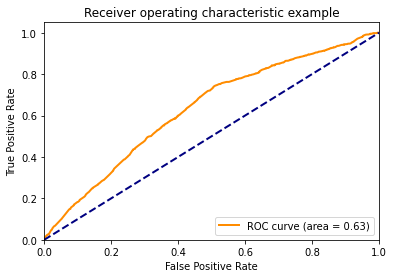

In [15]:
# Define AdaBoost Classifier
cla = AdaBoostClassifier()

# Fit model on training data
cla.fit(X_train, y_train) 

# Predict on training data
# Predict probability
predict_prob = cla.predict_proba(X_train)
# Plot ROC curve
plot_roc(y_train, predict_prob[:,1])

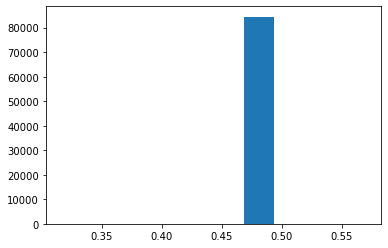

In [16]:
plt.hist(predict_prob[:,1]);

In [17]:
# Calculate predicted label using threshold 0.48 to maximize AUC
y_train_preds = np.where(predict_prob > 0.48, 1, 0)
# Print ROC score
print('ROC score: ', roc_auc_score(y_train, y_train_preds[:,1]))
# Print confusion matrix
confusion_matrix(y_train, y_train_preds[:,1]) 

ROC score:  0.5441788884876113


array([[73450, 10044],
       [  823,   217]], dtype=int64)

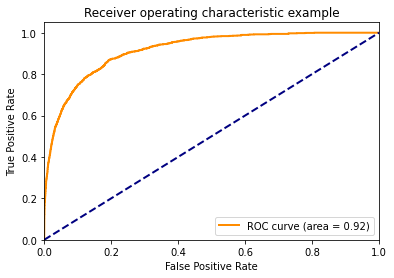

In [18]:
# Define XGBClassifier
xgbr = xgb.XGBClassifier(verbosity=0) 

# Fit model on training data
xgbr.fit(X_train, y_train) 

# Predict on training data
# Predict probability
predict_prob = xgbr.predict_proba(X_train)
# Plot ROC curve
plot_roc(y_train, predict_prob[:,1])

In [19]:
# Calculate predicted label using threshold 0.01 
y_train_preds = np.where(predict_prob > 0.01, 1, 0)
# Print ROC score
print('ROC score: ', roc_auc_score(y_train, y_train_preds[:,1]))
# Print confusion matrix
confusion_matrix(y_train, y_train_preds[:,1]) 

ROC score:  0.7682457606350341


array([[47684, 35810],
       [   36,  1004]], dtype=int64)

### <a class="anchor" id="part2.3"> 2.3 Optimize threshold </a>

Define function to find best threshold for predicted label to maximize IRR and NIR

In [24]:
def find_best_thres(df, predict_prob, thres_range):
    '''
    Function: 
    find best threshold to maximize IRR and NIR
    
    Input:
    df - 2D pandas dataframe
    predict_prob - 1D array of predcted purchase probability
    thres_range - 1D array of threshold range: [lower_bound, upper_bound]
    
    Output:
    thres_best - Real number of best threshold
    IRR_best = Real number of best IRR
    NIR_best = Real number of best NIR
    '''
    thres_best=[]
    IRR_best = -float('inf')
    NIR_best = -float('inf')
    for thres in np.linspace(thres_range[0], thres_range[1] , num=50):
        y_train_preds = np.where(predict_prob > thres, 1, 0)
        IRR, NIR = cal_IRR_NIR(df, y_train_preds[:,1],0)
        if (IRR > IRR_best) & (NIR > NIR_best):
            IRR_best = IRR
            NIR_best = NIR
            thres_best = thres
            
    return thres_best, IRR_best, NIR_best
    

In [25]:
thres_best, IRR_best, NIR_best = find_best_thres(train_data, predict_prob, [0.01, 0.05])
print(thres_best, IRR_best, NIR_best)

0.01653061224489796 0.006263953759424595 -3284.600000000006


## <a class="anchor" id="part3"> 3. Predict on test data </a> 

In [32]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    # Normalized X
    X = df[['V1','V2','V3','V4','V5','V6','V7']]
    X = preprocessing.StandardScaler().fit(X).transform(X)
    # Predict on df
    predict_prob = xgbr.predict_proba(X)
    y_preds = np.where(predict_prob > thres_best, 1, 0)
    # Assign promotion array
    promotion = np.array(['No' for _ in range(df.shape[0])], dtype = 'object')
    promotion[y_preds[:,1]==1] = 'Yes'
    
    return promotion

In [33]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0176.

Your nir with this strategy is 110.55.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.017596042925380175, 110.55000000000007)